# Agricultural Causal Estimation

In [103]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# DoWhy imports 
import dowhy
from dowhy import CausalModel
from dowhy import gcm

import sklearn

from sklearn.preprocessing import LabelEncoder

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
crops = ['sugarcane','wheat','grapes','cotton']
reqrain = [130,75,75,50]
reqtemp = [30,25,29,25]
critheat = [41,36,40,36]
critcold = [15,10,14,11]
places = ['Baramti','Latur','Nagpur','Ratnagiri']

In [69]:
cropcol = pd.Series('cotton')
tempcol = pd.Series(28)
reqtempcol = pd.Series(25)
reqraincol = pd.Series(50)
extremeheattemp = pd.Series(40)
extremecoldtemp = pd.Series(20)
criticalheattemp = pd.Series(38)
criticalcoldtemp=pd.Series(12)
raincol = pd.Series(60)
placescol = pd.Series('Baramati')
i=0

while i<1000:
    cropint=random.randint(0,3)
    rainint = random.randint(0,15)
    tempint = random.randint(0,5)
    plusminusint1 = random.randint(0,1)
    plusminusint2 = random.randint(0,1)
    placeint = random.randint(0,3)
    
    placescol.at[placescol.index[-1]+1] = places[placeint]
    cropcol.at[cropcol.index[-1]+1]=crops[cropint]
    if(plusminusint1==0):
        raincol.at[raincol.index[-1]+1]=reqrain[cropint]-rainint
        
    else:
        raincol.at[raincol.index[-1]+1]=reqrain[cropint]+rainint
    if(plusminusint2==0):
        tempcol.at[tempcol.index[-1]+1]=reqtemp[cropint]-tempint
    else:
        tempcol.at[tempcol.index[-1]+1]=reqtemp[cropint]+tempint
    
    reqtempcol.at[reqtempcol.index[-1]+1]=reqtemp[cropint]
    reqraincol.at[reqraincol.index[-1]+1]=reqrain[cropint]
    
    crithint= random.randint(0,11)
    critcold1 = random.randint(0,16)
    
    criticalheattemp.at[criticalheattemp.index[-1]+1]=critheat[cropint]
    criticalcoldtemp.at[criticalcoldtemp.index[-1]+1]=critcold[cropint]
    
    extremeheattemp.at[extremeheattemp.index[-1]+1]=reqtemp[cropint]+crithint
    extremecoldtemp.at[extremecoldtemp.index[-1]+1]=reqtemp[cropint]-critcold1
    
    i+=1
   

In [71]:
dict1 = {'Location':placescol,'CropType':cropcol,'AverageTemperatures(C)':tempcol,'RequiredAverageTemp(C)':reqtempcol,'CriticalHighTemp(C)':criticalheattemp
         ,'ExtremeHighTemp(C)': extremeheattemp, 'CriticalLowTemp(C)': criticalcoldtemp,'ExtremeLowTemp(C)':extremecoldtemp,'AverageAnnualRain(cm)':raincol,'RequiredAnnualRain(cm)':reqraincol}

In [72]:
agri = pd.DataFrame(dict1)
print(agri)

       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [73]:

soilcol=pd.Series(3)
sod=pd.Series('Sodic')
pHcol = pd.Series(8)
for i in range(1000):
    
    soilint = random.randint(0,12)
    soilcol.at[soilcol.index[-1]+1]=soilint
    sodint = random.randint(0,1)
    pHint = round(random.uniform(0, 1.5),1)
    
    if(sodint==0):
        sod.at[sod.index[-1]+1]='Non-Sodic'
    else:
        sod.at[sod.index[-1]+1]='Sodic'
    if(soilint<=6):
        if(sodint==0):
            pHcol.at[pHcol.index[-1]+1]=8+pHint
        else:
            pHcol.at[pHcol.index[-1]+1]=8-pHint
    else:
        if(sodint==0):
            pHcol.at[pHcol.index[-1]+1]=8-pHint
        else:
            pHcol.at[pHcol.index[-1]+1]=8+pHint
        
    

In [74]:
agri['SoilType'] = sod
agri['SoilSalinity(g/L)'] = soilcol
agri['pH'] = pHcol

In [75]:
print(agri)

       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [76]:
pesticide = pd.Series('Yes')
fertilizer = pd.Series('No')
insectdis = pd.Series(0.5)

In [77]:
for i in range(1000):
    
    pestint = random.randint(0,1)
    fertilizerint = random.randint(0,1)
    if(pestint==0):
        pesticide.at[pesticide.index[-1]+1]='No'
    else:
        pesticide.at[pesticide.index[-1]+1]='Yes'
    if(fertilizerint==0):
        fertilizer.at[fertilizer.index[-1]+1]='No'
    else:
        fertilizer.at[fertilizer.index[-1]+1]='Yes'
    insectint = round(random.uniform(0,1),1)
    
    insectdis.at[insectdis.index[-1]+1]=insectint

In [78]:
agri['PesticideUse'] = pesticide
agri['FertilizerUse'] = fertilizer
agri['InsectAndDiseaseRisk'] = insectdis
print(agri)

       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [79]:
artirig = pd.Series('Artificial')
harvest = pd.Series('Tractor')
sow = pd.Series('Seed Drill')
Drought = pd.Series(0)
Flood = pd.Series(0)

In [80]:
for i in range(1000):
   
    
    artiint = random.randint(0,1)
    harvestint = random.randint(0,1)
    sowint = random.randint(0,1)
    droughtint = round(random.uniform(0,1),1)
    floodint = round(random.uniform(0,1),1)
    
    if(artiint==0):
        artirig.at[artirig.index[-1]+1]='Artificial'
    else:
        artirig.at[artirig.index[-1]+1]='Natural'
    if(harvestint==0):
        harvest.at[harvest.index[-1]+1]='Tractor'
    else:
        harvest.at[harvest.index[-1]+1]='By Hand'
    if(sowint==0):
        sow.at[sow.index[-1]+1]='Seed Drill'
    else:
        sow.at[sow.index[-1]+1]='By Hand'
    Drought.at[Drought.index[-1]+1]=droughtint
    Flood.at[Flood.index[-1]+1]=floodint
    
    

In [81]:
agri['IrrigationMethod'] = artirig
agri['HarvestMethod'] = harvest
agri['SowingMethod'] = sow
agri['FloodRisk'] = Flood
agri['DroughtRisk']= Drought

In [82]:
print(agri)

       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

# Important Note: Actual Crop Survival (0: Didn't Survive and 1: Survived) needs to be pulled from actual data. This example uses randomized rates and thus its causal estimates shouldn't be held at face value.

In [83]:
success = pd.Series(0)

for i in range(1000):
   
    
    x = agri['AverageTemperatures(C)'][i] + agri['RequiredAverageTemp(C)'][i] + agri['ExtremeLowTemp(C)'][i] 
    + agri['SoilSalinity(g/L)'][i]
    
    x%=2
    
    success.at[success.index[-1]+1]=x
agri['CropSuccess'] = success
    
    
    

In [84]:
print(agri)

       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [87]:
practice = pd.Series(13)
i=1
while i<1001:
   
    
    x = 0
    if(agri['PesticideUse'][i]=='Yes'):
        x+=5
    
    if(agri['FertilizerUse'][i]=='Yes'):
        x+=3
    
    if(agri['IrrigationMethod'][i]=='Artificial'):
        x+=10
   
    if(agri['HarvestMethod'][i]=='Tractor'):
        x+=3
   
    if(agri['SowingMethod'][i]=='Seed Drill'):
        x+=5 
    
    
    practice.at[practice.index[-1]+1]=x
    
    i+=1
    
agri['Treatment'] = practice




for i in range(1001):
    if((agri['Treatment'][i])<12):
        agri['Treatment'][i]=0
    else:
        agri['Treatment'][i]=1

agri=agri.drop(['HarvestMethod','SowingMethod','IrrigationMethod','FertilizerUse','PesticideUse'],axis=1)
    

C:\Users\ISHAN\AppData\Local\Temp\ipykernel_7036\3936422570.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agri['Treatment'][i]=1
C:\Users\ISHAN\AppData\Local\Temp\ipykernel_7036\3936422570.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agri['Treatment'][i]=0


In [88]:
print(agri)



       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [42]:
agri.to_csv('AgriculturalDataset')

In [104]:
#Discretising

non_numeric_columns = list(agri.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    agri[col] = le.fit_transform(agri[col])
    
print(agri)

      Location  CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0            0         0                      28                      25   
1            4         0                      29                      25   
2            4         3                      27                      25   
3            2         2                      30                      30   
4            1         2                      32                      30   
...        ...       ...                     ...                     ...   
996          3         0                      24                      25   
997          1         3                      25                      25   
998          3         0                      25                      25   
999          2         2                      25                      30   
1000         3         1                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(C)  \
0                 

 # Loading the data into DoWhy

In [57]:
import graphviz



digraph {
	Location -> "AverageTemperatures(C)"
	Location -> "AverageAnnualRain(cm)"
	Location -> SoilType
	"AverageAnnualRain(cm)" -> FloodRisk
	"AverageAnnualRain(cm)" -> DroughtRisk
	"AverageTemperatures(C)" -> "ExtremeHighTemp(C)"
	"AverageTemperatures(C)" -> "ExtremeLowTemp(C)"
	SoilType -> "SoilSalinity(g/L)"
	"SoilSalinity(g/L)" -> pH
	CropType -> "RequiredAverageTemp(C)"
	CropType -> "RequiredAnnualRain(cm)"
	CropType -> "CriticalHighTemp(C)"
	CropType -> "CriticalLowTemp(C)"
	CropType -> InsectAndDiseaseRisk
	InsectAndDiseaseRisk -> CropSuccess
	"RequiredAverageTemp(C)" -> CropSuccess
	"RequiredAnnualRain(cm)" -> CropSuccess
	"CriticalHighTemp(C)" -> CropSuccess
	"CriticalLowTemp(C)" -> CropSuccess
	pH -> CropSuccess
	"ExtremeHighTemp(C)" -> CropSuccess
	"ExtremeLowTemp(C)" -> CropSuccess
	"FloodRisk  " -> CropSuccess
	DroughtRisk -> CropSuccess
	Treatment -> CropSuccess
}



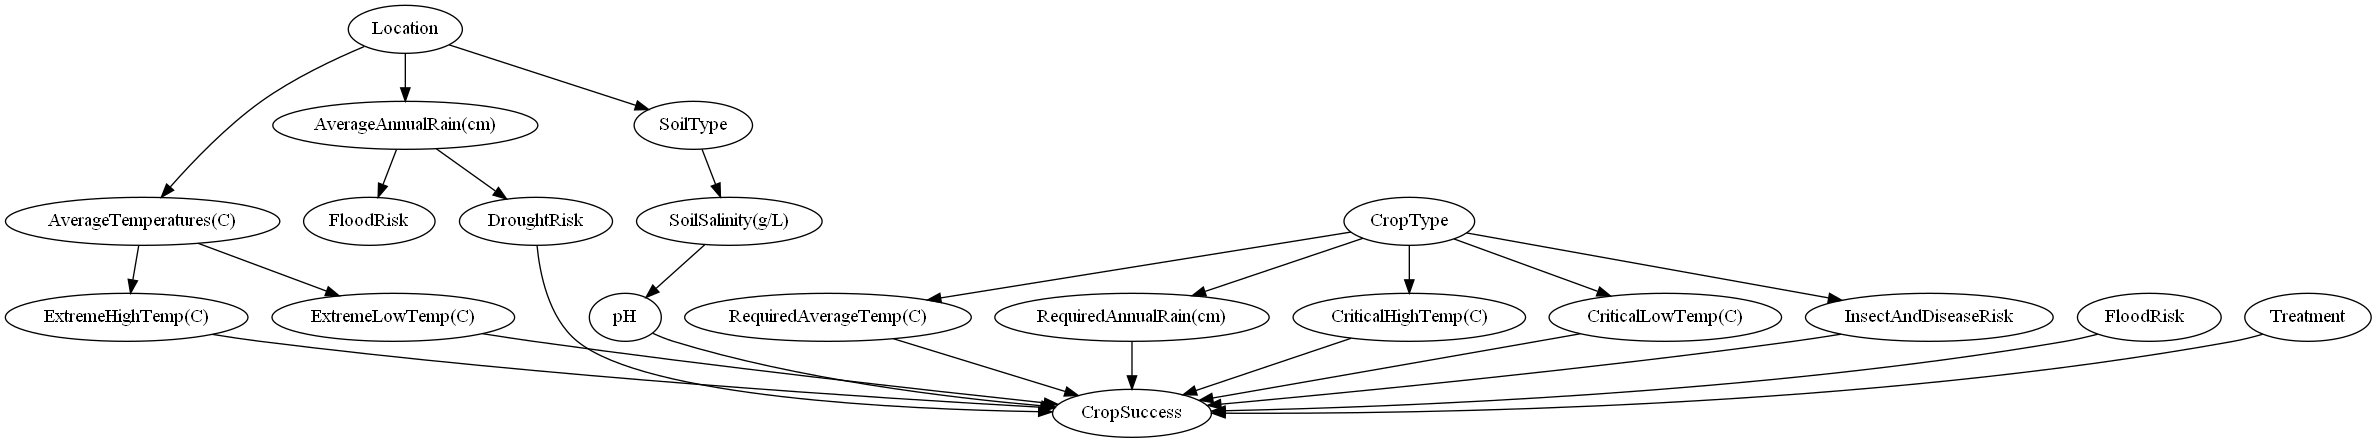

In [97]:
from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.edge('Location', 'AverageTemperatures(C)')  
dot.edge('Location', 'AverageAnnualRain(cm)')
dot.edge('Location', 'SoilType')
dot.edge('AverageAnnualRain(cm)', 'FloodRisk')
dot.edge('AverageAnnualRain(cm)','DroughtRisk')
 
dot.edge('AverageTemperatures(C)','ExtremeHighTemp(C)')
dot.edge('AverageTemperatures(C)', 'ExtremeLowTemp(C)')
dot.edge('SoilType', 'SoilSalinity(g/L)')
dot.edge('SoilSalinity(g/L)', 'pH')
dot.edge('CropType','RequiredAverageTemp(C)')

dot.edge('CropType','RequiredAnnualRain(cm)')
dot.edge('CropType','CriticalHighTemp(C)')
dot.edge('CropType','CriticalLowTemp(C)')
dot.edge('CropType','InsectAndDiseaseRisk')
dot.edge('InsectAndDiseaseRisk','CropSuccess')
dot.edge('RequiredAverageTemp(C)','CropSuccess')
dot.edge('RequiredAnnualRain(cm)','CropSuccess')
dot.edge('CriticalHighTemp(C)','CropSuccess')
dot.edge('CriticalLowTemp(C)','CropSuccess')
dot.edge('pH','CropSuccess')
dot.edge('ExtremeHighTemp(C)','CropSuccess')
dot.edge('ExtremeLowTemp(C)','CropSuccess')
dot.edge('FloodRisk  ','CropSuccess')
dot.edge('DroughtRisk','CropSuccess')
dot.edge('Treatment','CropSuccess')
print(dot.source)

dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="doctest-output/Digraph.gv.png"))

In [98]:
# Define estimator inputs
Y = agri['CropSuccess']

T= agri['Treatment']

X=agri.drop(['CropSuccess','Treatment'],axis=1)



       Location   CropType  AverageTemperatures(C)  RequiredAverageTemp(C)  \
0      Baramati     cotton                      28                      25   
1     Ratnagiri     cotton                      29                      25   
2     Ratnagiri      wheat                      27                      25   
3         Latur  sugarcane                      30                      30   
4       Baramti  sugarcane                      32                      30   
...         ...        ...                     ...                     ...   
996      Nagpur     cotton                      24                      25   
997     Baramti      wheat                      25                      25   
998      Nagpur     cotton                      25                      25   
999       Latur  sugarcane                      25                      30   
1000     Nagpur     grapes                      33                      29   

      CriticalHighTemp(C)  ExtremeHighTemp(C)  CriticalLowTemp(

In [ ]:
model = dowhy.CausalModel(data=X,
                     graph=dot.replace("\n", " "),
                     treatment="Treatment",
                     outcome="CropSuccess")
model.view_model()


In [ ]:
est = LinearIntentToTreatDRIV(model_t_xwz=model_T_XZ, model_y_xw=model_Y_X,
                            flexible_model_effect=flexible_model_effect,
                            featurizer=PolynomialFeatures(degree=1, include_bias=False))

# fit through dowhy
test_data = X.iloc[:1000]
est_dw=est.dowhy.fit(Y, T, X=X, outcome_names=["CropSuccess"], treatment_names=["Treatment"], 
                     feature_names=list(X.columns.values), target_units=test_data,
                     inference="statsmodels")